In [ ]:
import numpy as np
import cvxpy as cp
#definition
files = 100
T = 5000
max_cache_size = 20
x = cp.Variable(files)
utils = np.tile(np.array([1]), (1, files ))[0]
grads = []
acc_grad = np.zeros(files)
acc_r = 0
sigmas = []
ht = []
cost = [1]
action = []
#problem constraints
standard_constraints = [x>=0, x<=1, cp.sum(x)<=max_cache_size]

In [ ]:
#sigma
def calc_sigma(sigmas, ht, grads, pred):
  if len(grads)<2:  # no grads yet
      ht.append(1)  # for t=0
      sigmas.append(1 / ht[-1])  
  else:
      ht.append(
          np.linalg.norm(grads[-2] - pred, 2) ** 2)  
      sigmas.append(np.sqrt(sum(ht)) - np.sqrt(sum(ht)-ht[-1]))
  return sigmas,ht

def generate_cost(files, utils, action):  # this is generating r
    r = np.zeros(files) 
    requested_id = Zipf(1.2, 1, files) - 1
    requested_id = int(requested_id)
    r[requested_id] = -1
    extended_r = np.repeat(r, 1)
    grad = utils * extended_r

    if len(action) != 0:
      cost.append(cost[-1]+1-action[-1][requested_id])

    return grad, cost

def Zipf(a: np.float64, min: np.uint64, max: np.uint64, size=None):
    """
    Generate Zipf-like random variables,
    but in inclusive [min...max] interval
    """
    if min == 0:
        raise ZeroDivisionError("")
    v = np.arange(min, max + 1)  # values to sample
    p = 1.0 / np.power(v, a)  # probabilities
    p /= np.sum(p)  # normalized

    return np.random.choice(v, size=size, replace=True, p=p)

In [ ]:
def steps(grad,grads,files,action,acc_r,acc_grad,sigmas,ht):
  pred = grad

  if not action: 
    yy = cp.sum_squares(x - np.random.rand(files))
  else:
    acc_r += (sigmas[-1]/2) * cp.sum((x-action[-1])**2)
    yy = acc_r + (acc_grad + pred) @ x

  objective = cp.Minimize(yy)
  problem = cp.Problem(objective, standard_constraints)
  result = problem.solve(warm_start=True)

  #print(x.value)
  action.append(x.value)

  grads.append(grad)
  acc_grad += grads[-1]
  sigmas, ht = calc_sigma(sigmas, ht, grads, pred)

  return grads,acc_grad,sigmas,ht,acc_r,action

In [ ]:
# main process
for i in range(1,T+1):
  print(i)
  grad, cost = generate_cost(files, utils, action)
  grads,acc_grad,sigmas,ht,acc_r,action = steps(grad,grads,files,action,acc_r,acc_grad,sigmas,ht)
  if i%100 ==0:
    np.save('/content/drive/MyDrive/data online learning/cost_obc.npy',np.array(cost))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
np.save('cost_obc.npy',np.array(cost))

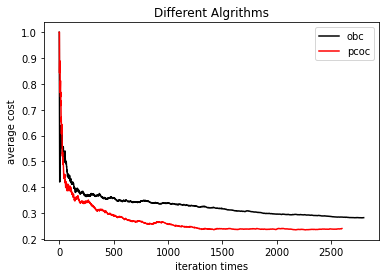

In [ ]:
#figure
import numpy as np
average_cost_obc = np.load('/content/drive/MyDrive/data online learning/cost_obc.npy')
average_cost_pcoc = np.load('/content/drive/MyDrive/data online learning/cost_pcoc.npy')
len_obc = len(average_cost_obc)
len_pcoc = len(average_cost_pcoc)
average_cost_oftrl_obc= average_cost_obc / np.arange(1, len_obc+1)
average_cost_oftrl_pcoc= average_cost_pcoc / np.arange(1, len_pcoc+1)

import matplotlib as mpl
import matplotlib.pyplot as plt

plt.title('Different Algrithms')
plt.plot(np.array(range(len_obc)), average_cost_oftrl_obc, color='black', label='obc')
plt.plot(np.array(range(len_pcoc)), average_cost_oftrl_pcoc, color='red', label='pcoc')
plt.legend()

plt.xlabel('iteration times')
plt.ylabel('average cost')
plt.show()